<div class="alert alert-info">
<h1>Count Regression</h1>
<h4>Environmental Statistics 2</h4>
I.E. Azuh/C.F. Dormann
</div>

In today's session on count regression, our focus lies on mastering the use of model dispersion to distinguish between Poisson and negative binomial distributions. Count regression models are essential for analyzing data where the outcome variable represents counts, such as the number of events or occurrences.

By understanding model dispersion, we gain insights into the variability of count data and the appropriateness of different distributional assumptions. Specifically, we'll delve into techniques for assessing overdispersion, a common issue in count data analysis where the variance exceeds the mean.

Through practical examples and hands-on exercises, we'll learn how to interpret model dispersion measures and make informed decisions about model selection. By the end of the session, participants will have a solid understanding of count regression techniques and the ability to effectively diagnose and address dispersion issues in their analyses. This knowledge is crucial for accurate modeling and interpretation of count data in various fields, including epidemiology, economics, and ecology.
 

### 1.0  Exercise 1 
It is not always easy to find good environmental data, so here we resort to a political analysis of military coups in sub-Saharan Africa (since independence of many countries in 1989). 

In [2]:
# Call the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import scipy


In [4]:
# call dataset
africa = pd.read_csv("africa.csv")

# Reset the index by replacing with country
africa = africa.set_index('country')
africa.describe()

,miltcoup,oligarchy,pollib,parties,pctvote,popn,size,numelec,numregim
count,47.000000,47.000000,42.000000,47.000000,41.000000,47.000000,47.000000,47.000000,47.000000
mean,1.404255,4.446809,1.666667,15.957447,31.881220,10.953064,516.712766,6.191489,2.510638
std,1.715144,5.751403,0.570266,11.458730,17.465135,18.558382,591.161189,3.876564,1.018787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.067000,0.500000,0.000000,1.000000
25%,0.000000,0.000000,1.000000,10.000000,18.900000,1.450000,33.000000,4.000000,2.000000
50%,1.000000,1.000000,2.000000,13.000000,28.950000,5.600000,274.000000,6.000000,3.000000
75%,2.000000,9.000000,2.000000,19.000000,43.040000,11.450000,813.000000,8.500000,3.000000
max,6.000000,18.000000,2.000000,62.000000,77.400000,113.800000,2506.000000,14.000000,4.000000


In [3]:
africa.head()

,miltcoup,oligarchy,pollib,parties,pctvote,popn,size,numelec,numregim
country,,,,,,,,,
Angola,0,0,2.0,38,NaN,9.7,1247.0,0,1
Benin,5,7,1.0,34,45.68,4.6,113.0,8,3
Botswana,0,0,NaN,7,20.30,1.2,582.0,5,1
Burkina,6,13,2.0,62,17.50,8.8,274.0,5,3
Burundi,2,13,2.0,10,34.39,5.3,28.0,3,3


### 1.1  Plot data
Plot the effect of number of successful military coups (‘miltcoup’) as a function of number of years ruled by military (since 1989).

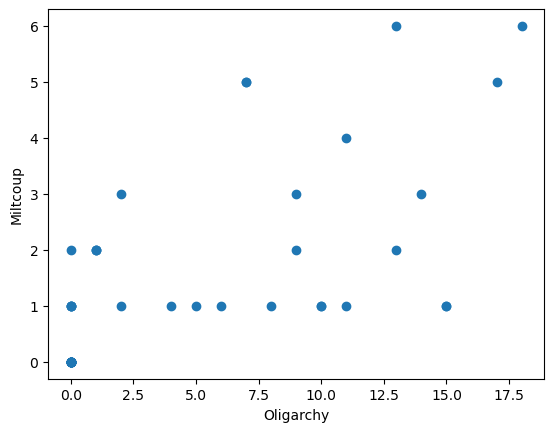

In [5]:
# The plot
plt.scatter(x="oligarchy", y="miltcoup", data=africa)
plt.xlabel("Oligarchy")
plt.ylabel("Miltcoup")
plt.show()

### 1.2  Plot data with transformed data
Both variables are count data, and often they benefit from square-root or logarithmic transformation. The reason is that the Poisson and negative binomial distribution are right-skewed and hence such a transformation makes the variables more akin to the symmetric distribution our eyes are used to. (Of course there is nothing wrong with plotting the data as they are!) <br>
Also count distributions typically use a logarithmic link, and hence such a transformation would simulate what the y-axis looks like at the link scale. (Note that for any base 𝑏: log<sub>b</sub> 0 = −$\infty$, hence it is common to see a value of 1 added to the response variable for plotting only.)


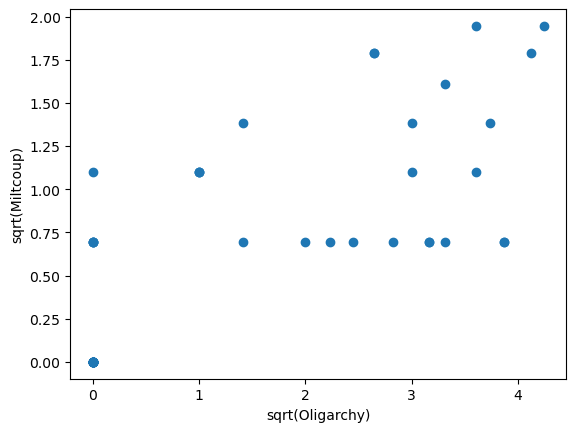

In [6]:
# log root Transformed miltcoup
# square root Transformed oligarchy

# the plot

plt.scatter(x=np.sqrt(africa['oligarchy']), y=np.log(africa['miltcoup']+1))
plt.xlabel("sqrt(Oligarchy)")
plt.ylabel("sqrt(Miltcoup)")
plt.show()

### 1.3  Analyse, assuming a Poisson distribution
Analyse effect of square-root transformed years of military oligarchy on military coups, assuming a Poisson distribution (for the response).

In [8]:
expr = """miltcoup ~ np.sqrt(oligarchy)"""

y, X = dmatrices(expr, africa, return_type='dataframe')


# Poisson 
fpois = sm.GLM(y, X, family=sm.families.Poisson()).fit()
fpois.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               miltcoup   No. Observations:                   47
Model:                            GLM   Df Residuals:                       45
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -61.504
Date:                Mon, 18 Mar 2024   Deviance:                       49.329
Time:                        11:50:07   Pearson chi2:                     48.6
No. Iterations:                     5   Pseudo R-squ. (CS):             0.6132
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.7901      0.269     -2.935      0.003      -1.318      -0.262
np.sqrt(oligarchy)     0.5399      0.088      6.131      0.000       0.367       0.713
======================================================================================
"""

### 1.4   What does the dispersion look like?

In [9]:
# dispersion
fpois.deviance/fpois.df_resid


1.0961894810369244

*Answer*: Looks good!

### 1.5  Analyse, assuming a negative binomial distribution
Poisson model was good, nevertheless, run an analysis assuming a negative binomial distribution.

**First: what alpha value to use?** <br>
Before fitting the Negative binomial, we need to first estimate the what `alpha` value to use? To achieve this, we do the following:

1.  Extract the `fpois.mu` as λ vector from the regression results and add as a new column called ‘my_lambda’ to the DataFrame.
2.  Next, add the expression [(Yi-λi)^2-λi]/λi =  α*λi + 0. This new column will store the values of the dependent variable of the OLS regression.
3.  Fit OLS regression of `lambda` on `ols_expression` without intercept, and obtain alpha value from (`OLSResults.params`).
4.  The OLSResults object contains the t-score of the regression coefficient α (`OLSResults.tvalues`). 

In [14]:
# 1.
africa2 = africa.copy()
africa2['lambda_'] = fpois.mu

# 2.
africa2['ols_dep'] = africa2.apply(lambda x: ((x['miltcoup'] - x['lambda_'])**2 - x['lambda_']) / x['lambda_'], axis=1)

# 3.
ols_expr = """ols_dep ~ lambda_ - 1"""  # do not to use an intercept of regression
olsr_results = smf.ols(ols_expr, africa2).fit()
print("The alpha value is :" ,olsr_results.params)

# 4.
print("The t-value is :" ,olsr_results.tvalues)


The alpha value is : lambda_    0.047552
dtype: float64
The t-value is : lambda_    0.454674
dtype: float64


Here our α=0.047552. Recall that the variance formular is Var = mu + α*mu, so if α=0, then variance will be = mean.
If the value of α is statistically not significant, then the Negative Binomial regression model cannot do a better job of fitting the training data set than a Poisson regression model.
We see that the alpha value (0.047552) is comfortably less than the t-statistic of α which was 0.454674.
We conclude that, α = 0.047552 is statistically significantly.

In [8]:
# Negative binomial

fnb = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=0.05)).fit() 
fnb.summary() 


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               miltcoup   No. Observations:                   47
Model:                            GLM   Df Residuals:                       45
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -61.403
Date:                Fri, 08 Mar 2024   Deviance:                       46.052
Time:                        12:14:33   Pearson chi2:                     45.4
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5891
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.7983      0.275     -2.904      0.004      -1.337      -0.260
np.sqrt(oligarchy)     0.5439      0.091      5.948      0.000       0.365       0.723
======================================================================================
"""

#### BONUS! : Assuming generalized poisson

In [9]:
# GP-1
gen_pois_gp1 = sm.GeneralizedPoisson(y, X, p=1).fit()

print(gen_pois_gp1.summary())

Optimization terminated successfully.
         Current function value: 1.305874
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11
                    GeneralizedPoisson Regression Results                     
Dep. Variable:               miltcoup   No. Observations:                   47
Model:             GeneralizedPoisson   Df Residuals:                       45
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Mar 2024   Pseudo R-squ.:                  0.1992
Time:                        12:14:49   Log-Likelihood:                -61.376
converged:                       True   LL-Null:                       -76.640
Covariance Type:            nonrobust   LLR p-value:                 3.290e-08
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -

In [10]:
# GP-2
gen_pois_gp2 = sm.GeneralizedPoisson(y, X, p=2).fit()

print(gen_pois_gp2.summary())

Optimization terminated successfully.
         Current function value: 1.306481
         Iterations: 10
         Function evaluations: 15
         Gradient evaluations: 15
                    GeneralizedPoisson Regression Results                     
Dep. Variable:               miltcoup   No. Observations:                   47
Model:             GeneralizedPoisson   Df Residuals:                       45
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Mar 2024   Pseudo R-squ.:                  0.1988
Time:                        12:15:04   Log-Likelihood:                -61.405
converged:                       True   LL-Null:                       -76.640
Covariance Type:            nonrobust   LLR p-value:                 3.388e-08
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             

What are the values for dispersion, and, importantly, for the scale-parameter “alpha”? Remember that lim<sub>alpha → 0 </sub>, negative binomial = Poisson. For all practical purposes, values < 0.01 or so can be considered “almost zero”.

### 1.6   Compare Poisson and negative binomial fit
So which fit is better?. Do a formal comparison using AIC and a likelihood-ratio test (LRT). Maybe you now realise that the LRT was a trick question! The likelihood-ratio test assumes that the two models compared are nested. You can do the LRT manually,
by computing the log-likelihoods of both models and compute the p-value based on a 𝜒2 - distribution with one degree of freedom:

In [11]:
# Compare the aic of the models

print('AIC(fpois) = ', round(fpois.aic, 4))
print('AIC(fnb)   = ', round(fnb.aic, 4))

# calculate log-likelihood of the models of interest
fpois_ll = fpois.llf
fnb_ll = fnb.llf

# calculate likelihood ratio Chi-Squared test statistic
LR_statistic = -2*(fpois_ll-fnb_ll)

#calculate p-value of test statistic using 1 degrees of freedom
p_val = scipy.stats.chi2.sf(LR_statistic, 1)

print()
print('Chi-Squared test statistic is ', round(LR_statistic, 4))
print('The p_value for the test statistic is ', round(p_val, 4))


AIC(fpois) =  127.0086
AIC(fnb)   =  126.8069

Chi-Squared test statistic is  0.2018
The p_value for the test statistic is  0.6533


From the output we can see that the Chi-Squared test-statistic is 0.2059 and the corresponding p-value is 0.65. Since this p-value is not less than .05, we will fail to reject the null hypothesis. This means that both models fit the data equally well. 

### 1.7  Plot with regression line and 95% CIs.
Make a production-quality scatterplot of the negative binomial regression result as a line into the original, untransformed plot. Note that you have to remember the sqrt-transformation of oligarchy in the model, and the link-function for the response!. *get_prediction(newdata)* function produces a response-type predictions that needs no exponentiation.

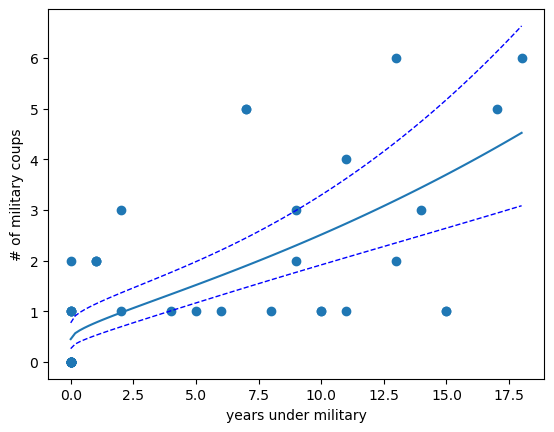

,mean,mean_se,mean_ci_lower,mean_ci_upper
0,0.450101,0.123727,0.262619,0.771427
1,0.566933,0.136860,0.353222,0.909946
2,0.623799,0.142245,0.398974,0.975312
3,0.671272,0.146347,0.437849,1.029135
4,0.714089,0.149789,0.473372,1.077215
...,...,...,...,...
96,4.317904,0.818837,2.977509,6.261709
97,4.368920,0.834812,3.004186,6.353623
98,4.420273,0.851007,3.030908,6.446521
99,4.471962,0.867423,3.057674,6.540411


In [12]:
# The scatter plot
plt.scatter(x="oligarchy", y="miltcoup", data=africa)
plt.xlabel("years under military")
plt.ylabel("# of military coups")


newOli_ = np.linspace(0, 18, num=101)  # as numpy.ndarray
Int_ = np.linspace(1.0, 1.0, num=101) # as numpy.ndarray

d = {'Intercept': list(Int_) , 'oligarchy': list(np.sqrt(newOli_))} # Convert to a dataframe
newOli = pd.DataFrame(data=d)                                      # oligarchy as sqrt(oligarchy)

preds = fnb.get_prediction(newOli).summary_frame(alpha=0.05) # response-type predictions

plt.plot(newOli_, preds['mean']) 
plt.plot(newOli_, preds['mean_ci_lower'], linestyle='dashed', color = "blue", linewidth=1.0)
plt.plot(newOli_, preds['mean_ci_upper'], linestyle='dashed', color = "blue", linewidth=1.0)


plt.show()
preds

Note that the link-scale straight line becomes an exponential curve. The transformation of the predictor is automatically taken care of during plotting, and it leads to the kink at the lowest x-values. <br>
This plot reveals one reason behind the belief of political scientists that military dictatorships do *not* stabilise nations, at least not in the long run.